__TODO: Check which channel need to be kept (green, or PCA of channels, or directly RBG to Grayscale__

# Import librairies

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, "/appli")
import cv2

plt.rcParams["figure.figsize"] = (15, 15)
from utile.pre_processing import PreProcessingPipeline

# Loading data

In [2]:
# Import train data
img_path = "../kaggle_dataset"
train_df = pd.read_csv("data/train.csv")
# Create the path of the image in the dataframe
train_df["path"] = train_df.apply(
    lambda x: "".join(
        [img_path, "/", str(x["patient_id"]), "_", str(x["image_id"]), ".png"]
    ),
    axis=1,
)

In [3]:
examples_list = [
    "1450_1185608765",
    "294_2044098614",
    "1461_1322198700",
    "1511_764545189",
    "1468_893864802",
    "1475_86778676",
    "1479_1933359921",
    "1493_1074894518",
    "1499_14130510",
    "1499_1988370728",
    "1511_764545189",
    "1511_1031853445",
    "1550_1451929890",
    "1653_1271242363",
    "1660_135787921",
    "1701_1613351630",
    "1719_138770970",
    "1878_1490758028",
    "1899_540562039",
    "65525_751035345",
    "393_1702011739",  # Problem ultra bright zone
    "1939_841837846",  # Whole breast super bright
    "65456_247536669",  # Some ultra bright zone
    "65271_171953953",  # Label to remove
    "38739_1189630231",
    "1511_1273092690",
    "1511_1031853445",
]

examples_list_path = [
    "".join([img_path, "/", x.split("_")[0], "_", x.split("_")[1], ".png"])
    for x in examples_list
]

# Artefact removal

Works for both annotation's labels, vertical lines if not interescts with brest

In [4]:
Pipeline = PreProcessingPipeline()

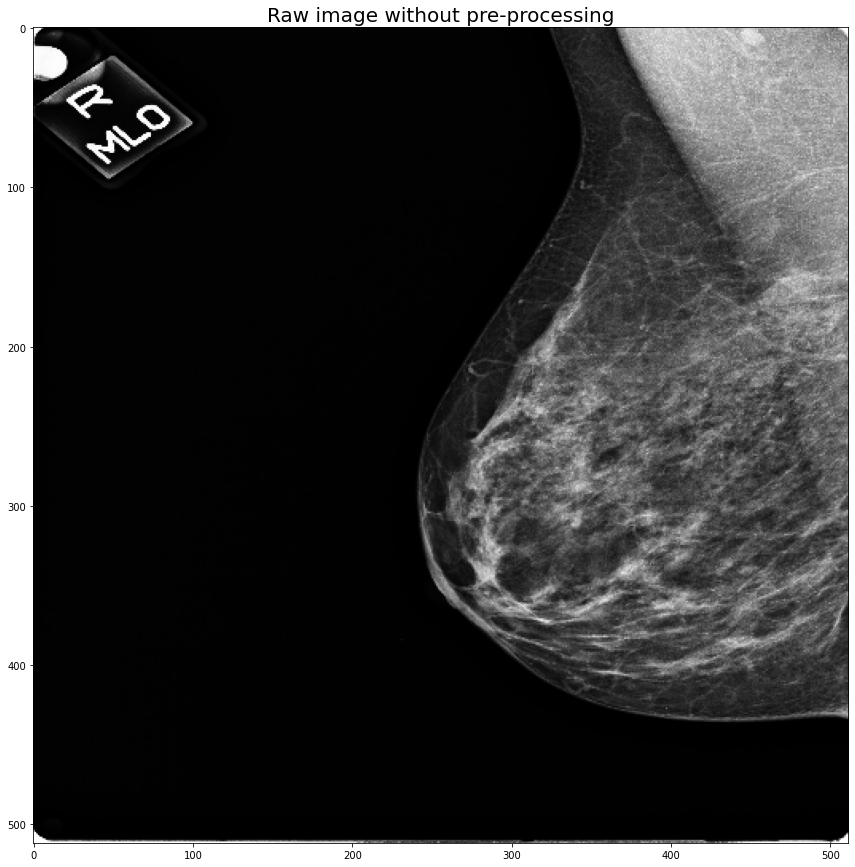

In [5]:
image = cv2.imread(examples_list_path[18])  # 10
plt.imshow(image, cmap="gray")
plt.title("Raw image without pre-processing", fontsize=20)
plt.show()

In [6]:
image = Pipeline._to_gray(image)

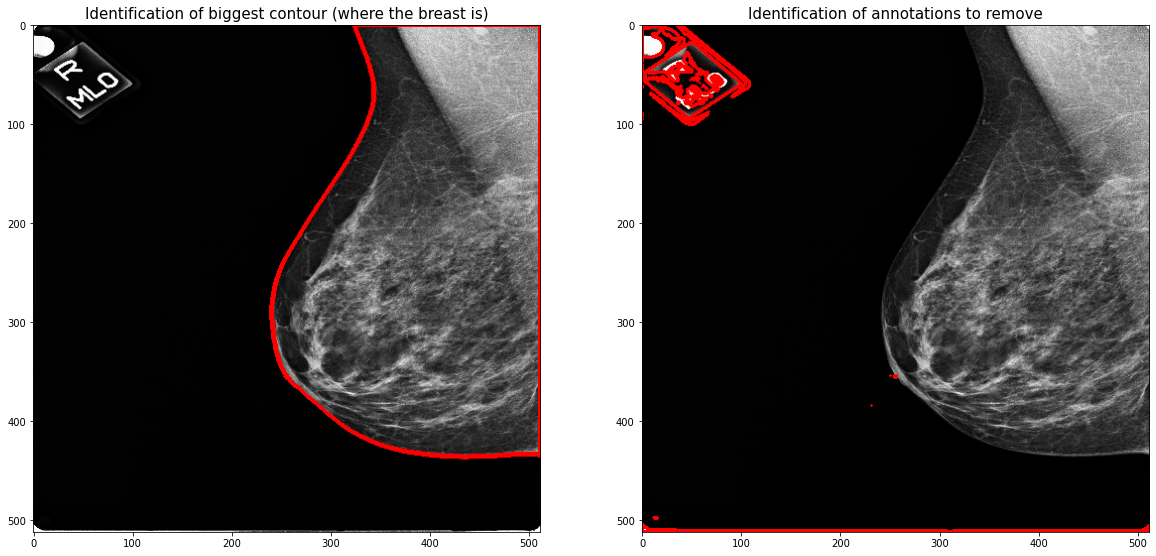

In [7]:
contours = Pipeline.get_contours(image)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(Pipeline.draw_contours(contours, image, biggest=True)[0])
ax1.set_title("Identification of biggest contour (where the breast is)", fontsize=15)
ax2.imshow(Pipeline.draw_contours(contours, image, biggest=False)[0])
ax2.set_title("Identification of annotations to remove", fontsize=15)
plt.show()

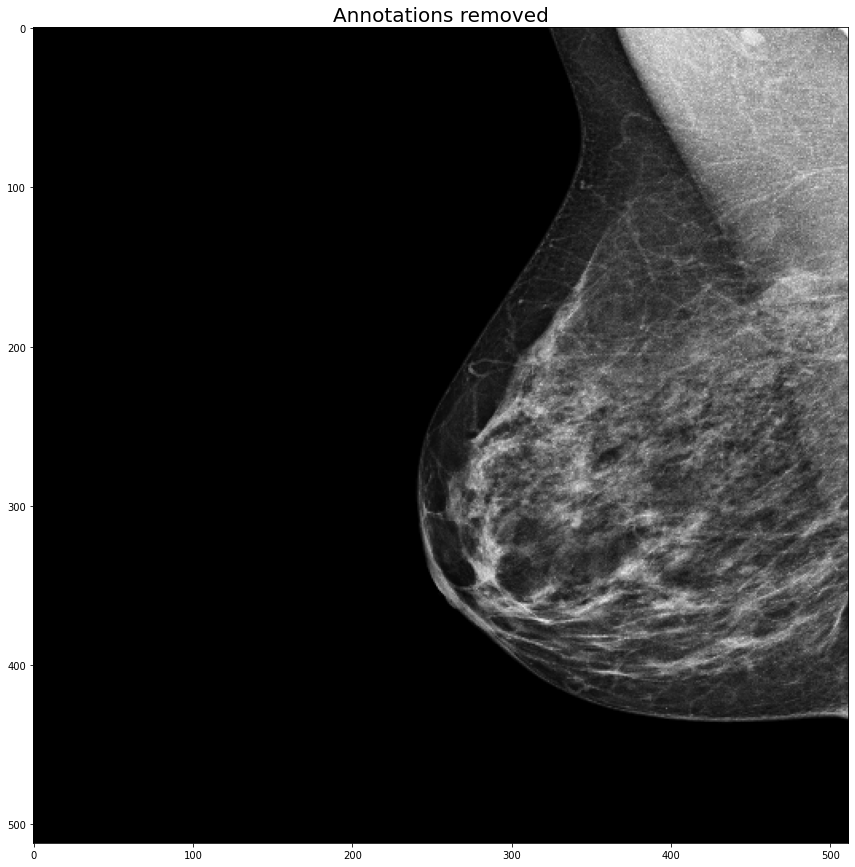

In [8]:
image_no_label = Pipeline._remove_annotation(image)[0]
plt.imshow(image_no_label, cmap="gray")
plt.title("Annotations removed", fontsize=20)
plt.show()

# Remove horizontal or vertical white lines or black lines at top or bottom

Detection of edges

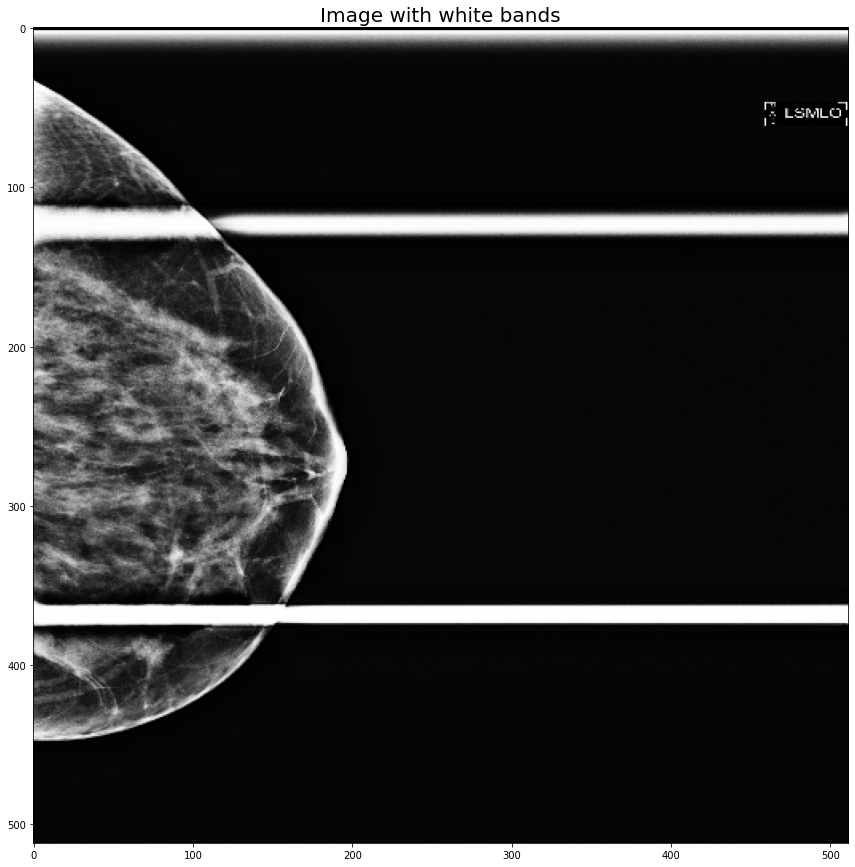

In [9]:
# img = cv2.imread(examples_list_path[-1])
image = cv2.imread(examples_list_path[10])
plt.imshow(image, cmap="gray")
plt.title("Image with white bands", fontsize=20)
plt.show()

In [10]:
img_lines, lines = Pipeline.get_horizontal_lines(image)

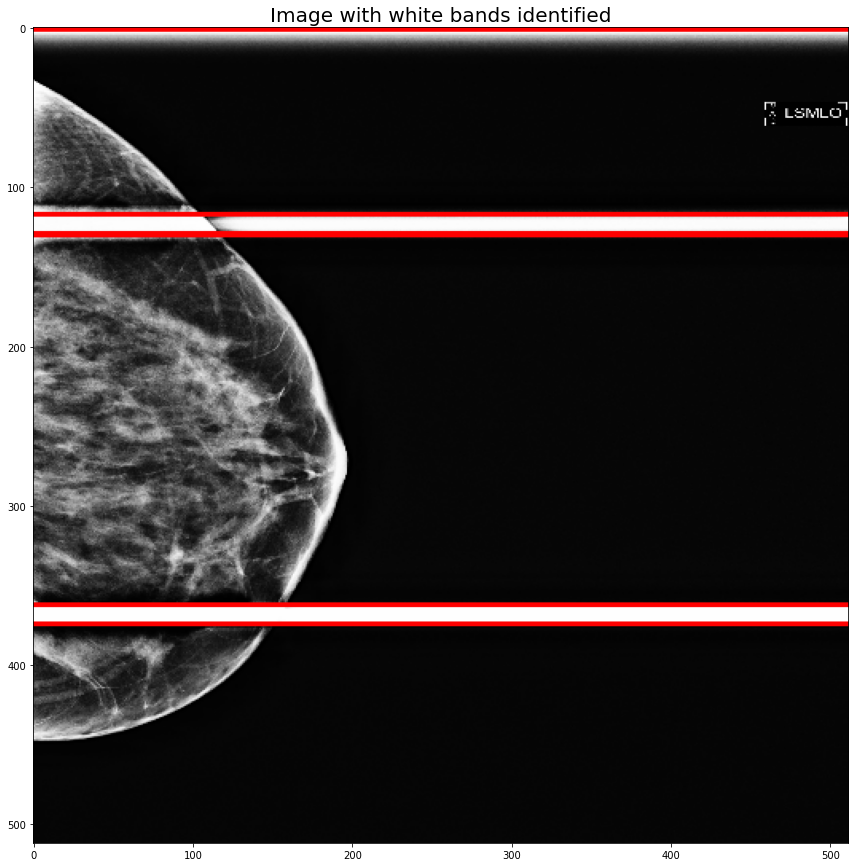

In [11]:
plt.imshow(img_lines, cmap="gray")
plt.title("Image with white bands identified", fontsize=20)
plt.show()

Detection of major horizontal lines (TODO do the same for vertical lines if there are) and TODO keep only 4 lines

__Rectangles have a height of around 10 pixels__

In [12]:
list_images = Pipeline.split_images_lines(image, filtered_lines=lines)

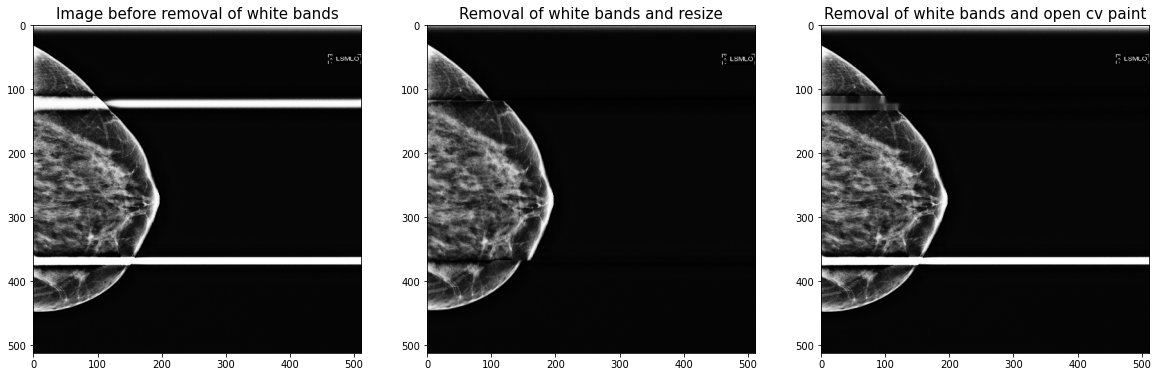

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

ax1.imshow(image)
ax1.set_title("Image before removal of white bands", fontsize=15)

ax2.imshow(
    Pipeline.restore_image(
        image=image,
        list_images=list_images,
        filtered_lines=lines,
        method="delete",
        thresh_low=0.1,
    )
)
ax2.set_title("Removal of white bands and resize", fontsize=15)

ax3.imshow(
    Pipeline.restore_image(
        image=image,
        list_images=list_images,
        filtered_lines=lines,
        method="opencv paint",
        thresh_low=0.1,
    )
)
ax3.set_title("Removal of white bands and open cv paint", fontsize=15)
plt.show()

__TODO: Explore masked ViT to restore white bands__

# Test (for ultra bright images with too bright zones)

__Try to reconstruct with ViT if possible__

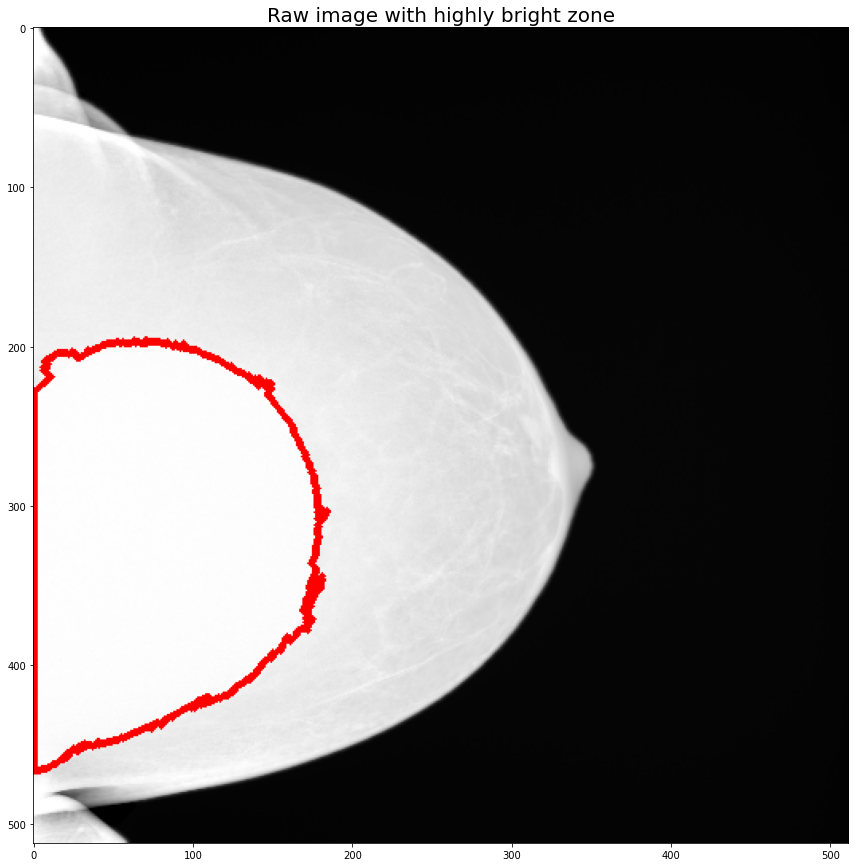

In [14]:
test = cv2.imread(examples_list_path[21])  # 10
test = Pipeline._to_gray(test)
contours = Pipeline.get_contours(test, thresh_low=245)
plt.imshow(Pipeline.draw_contours(contours, test, biggest=True)[0], cmap="gray")
plt.title("Raw image with highly bright zone", fontsize=20)
plt.show()

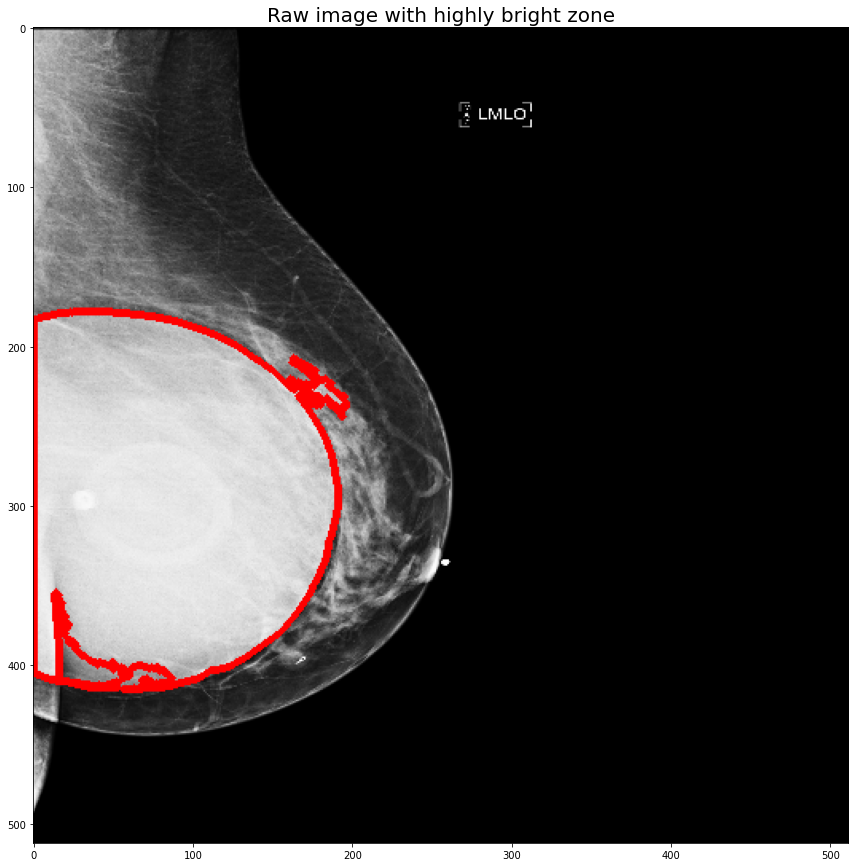

In [15]:
test = cv2.imread(examples_list_path[14])  # 10
test = Pipeline._to_gray(test)
contours = Pipeline.get_contours(test, thresh_low=170)
plt.imshow(Pipeline.draw_contours(contours, test, biggest=True)[0], cmap="gray")
plt.title("Raw image with highly bright zone", fontsize=20)
plt.show()

# Image normalization and enhancement

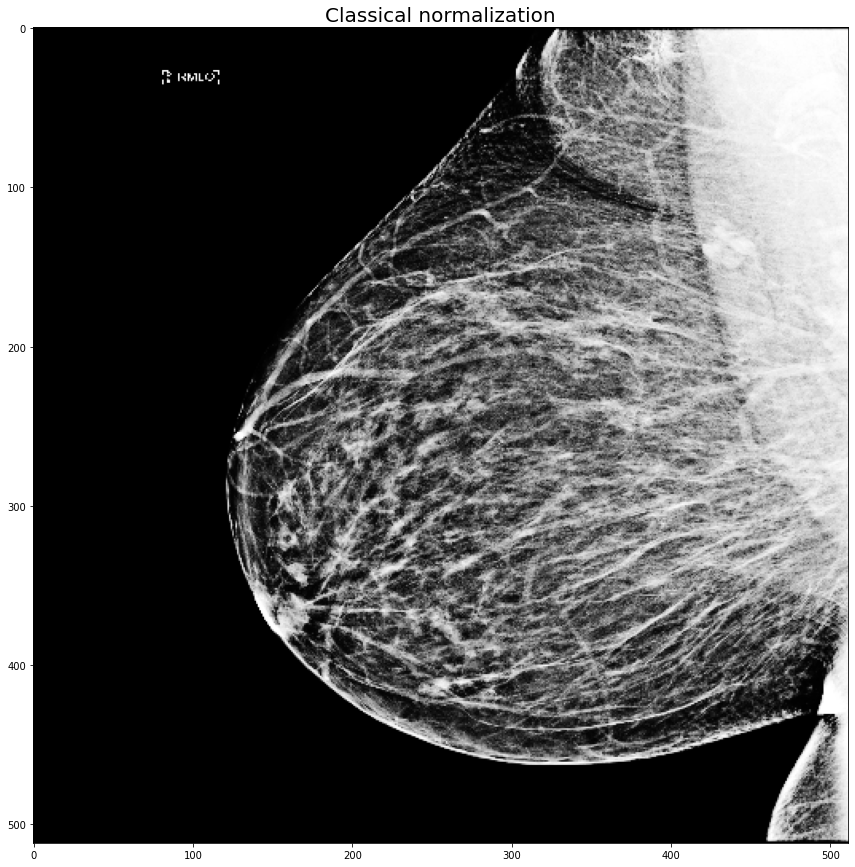

In [16]:
image = cv2.imread(examples_list_path[6])  # 18
image = Pipeline._to_gray(image)
plt.imshow(Pipeline.normalize(image, method="global"), cmap="gray")
plt.title("Classical normalization", fontsize=20)
plt.show()

__Might to be too harsh to apply a global histogram enhancement__

__With CLAE (cf. https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html)__

__TODO: Apply a mask on the contour for equalization__

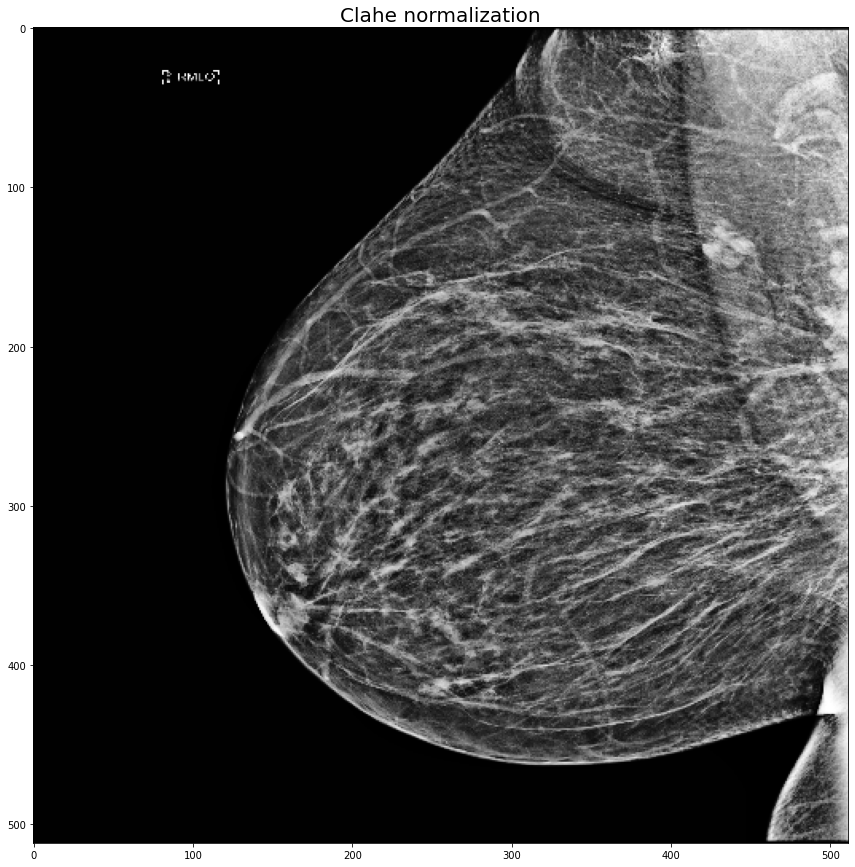

In [17]:
image = cv2.imread(examples_list_path[6])  # 18
image = Pipeline._to_gray(image)
plt.imshow(Pipeline.normalize(image), cmap="gray")
plt.title("Clahe normalization", fontsize=20)
plt.show()

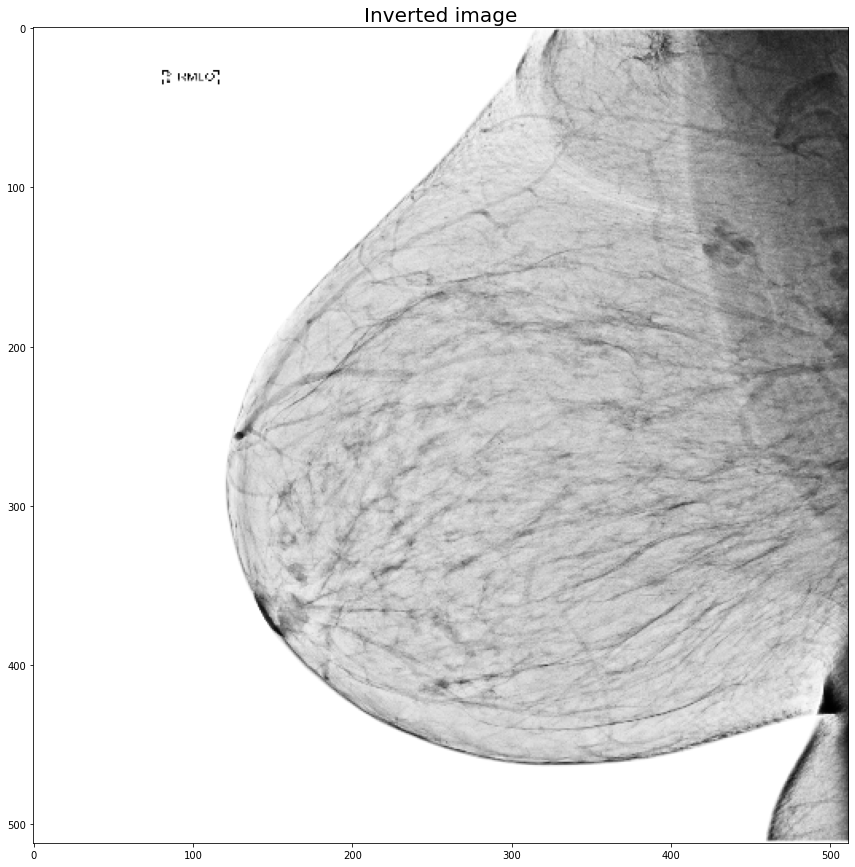

In [18]:
# Do we invert image?
image_reverted = Pipeline.invert_image(image)
plt.imshow(image_reverted, cmap="gray")
plt.title("Inverted image", fontsize=20)
plt.show()

# Image denoising?

In [19]:
img_denoized = Pipeline.denoise(image)

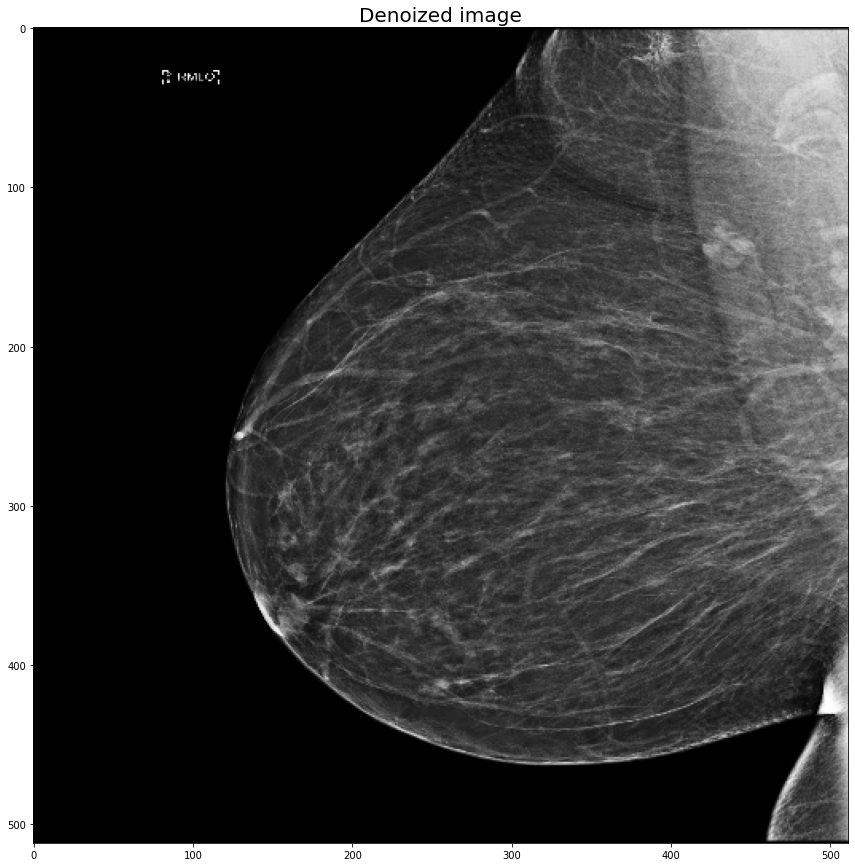

In [20]:
plt.imshow(img_denoized, cmap="gray")
plt.title("Denoized image", fontsize=20)
plt.show()

# Gamma correction?

In [21]:
img_gamma_corrected = Pipeline.gamma_correct(image)

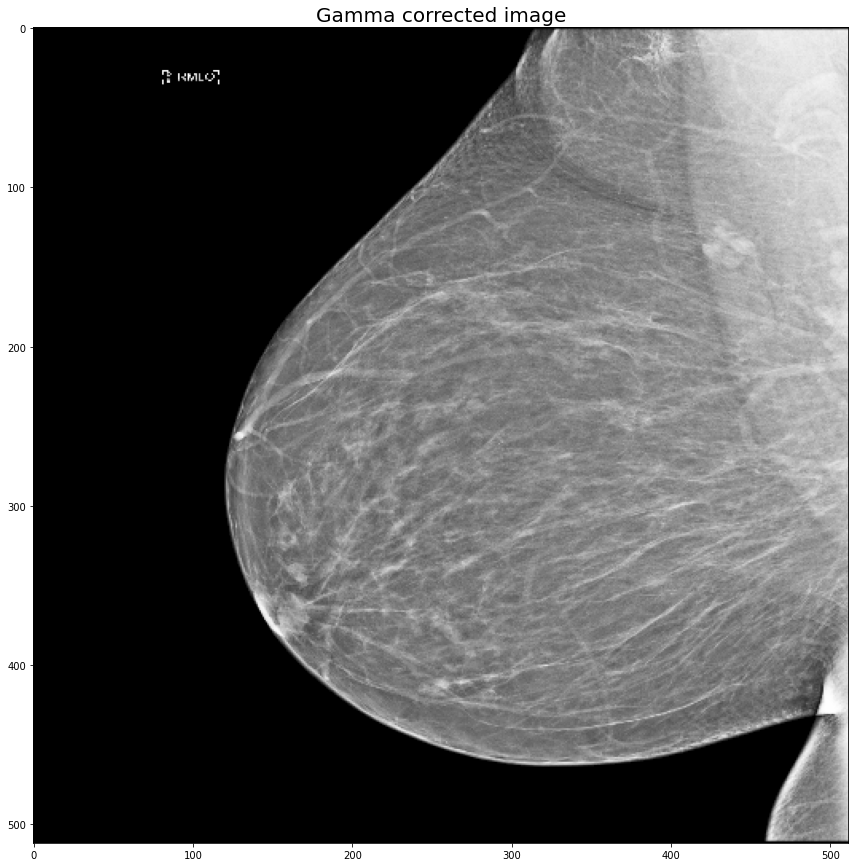

In [22]:
plt.imshow(img_gamma_corrected, cmap="gray")
plt.title("Gamma corrected image", fontsize=20)
plt.show()

# Image sharpening?

# Removal of pectoral muscles

In [23]:
Pipeline = PreProcessingPipeline(
    remove_annotation=True,
    denoising=True,
    gamma_correction=True,
    inverted_image=True,
    clahe_tileGridSize=(10, 10),
    clahe_clipLimit=1.0,
    pectoral_muscle = False,
)
image = cv2.imread(examples_list_path[2])  # 10
image = Pipeline._to_gray(image)
image = Pipeline.pre_process(image)

In [24]:
edges = Pipeline.get_edges(image=image)

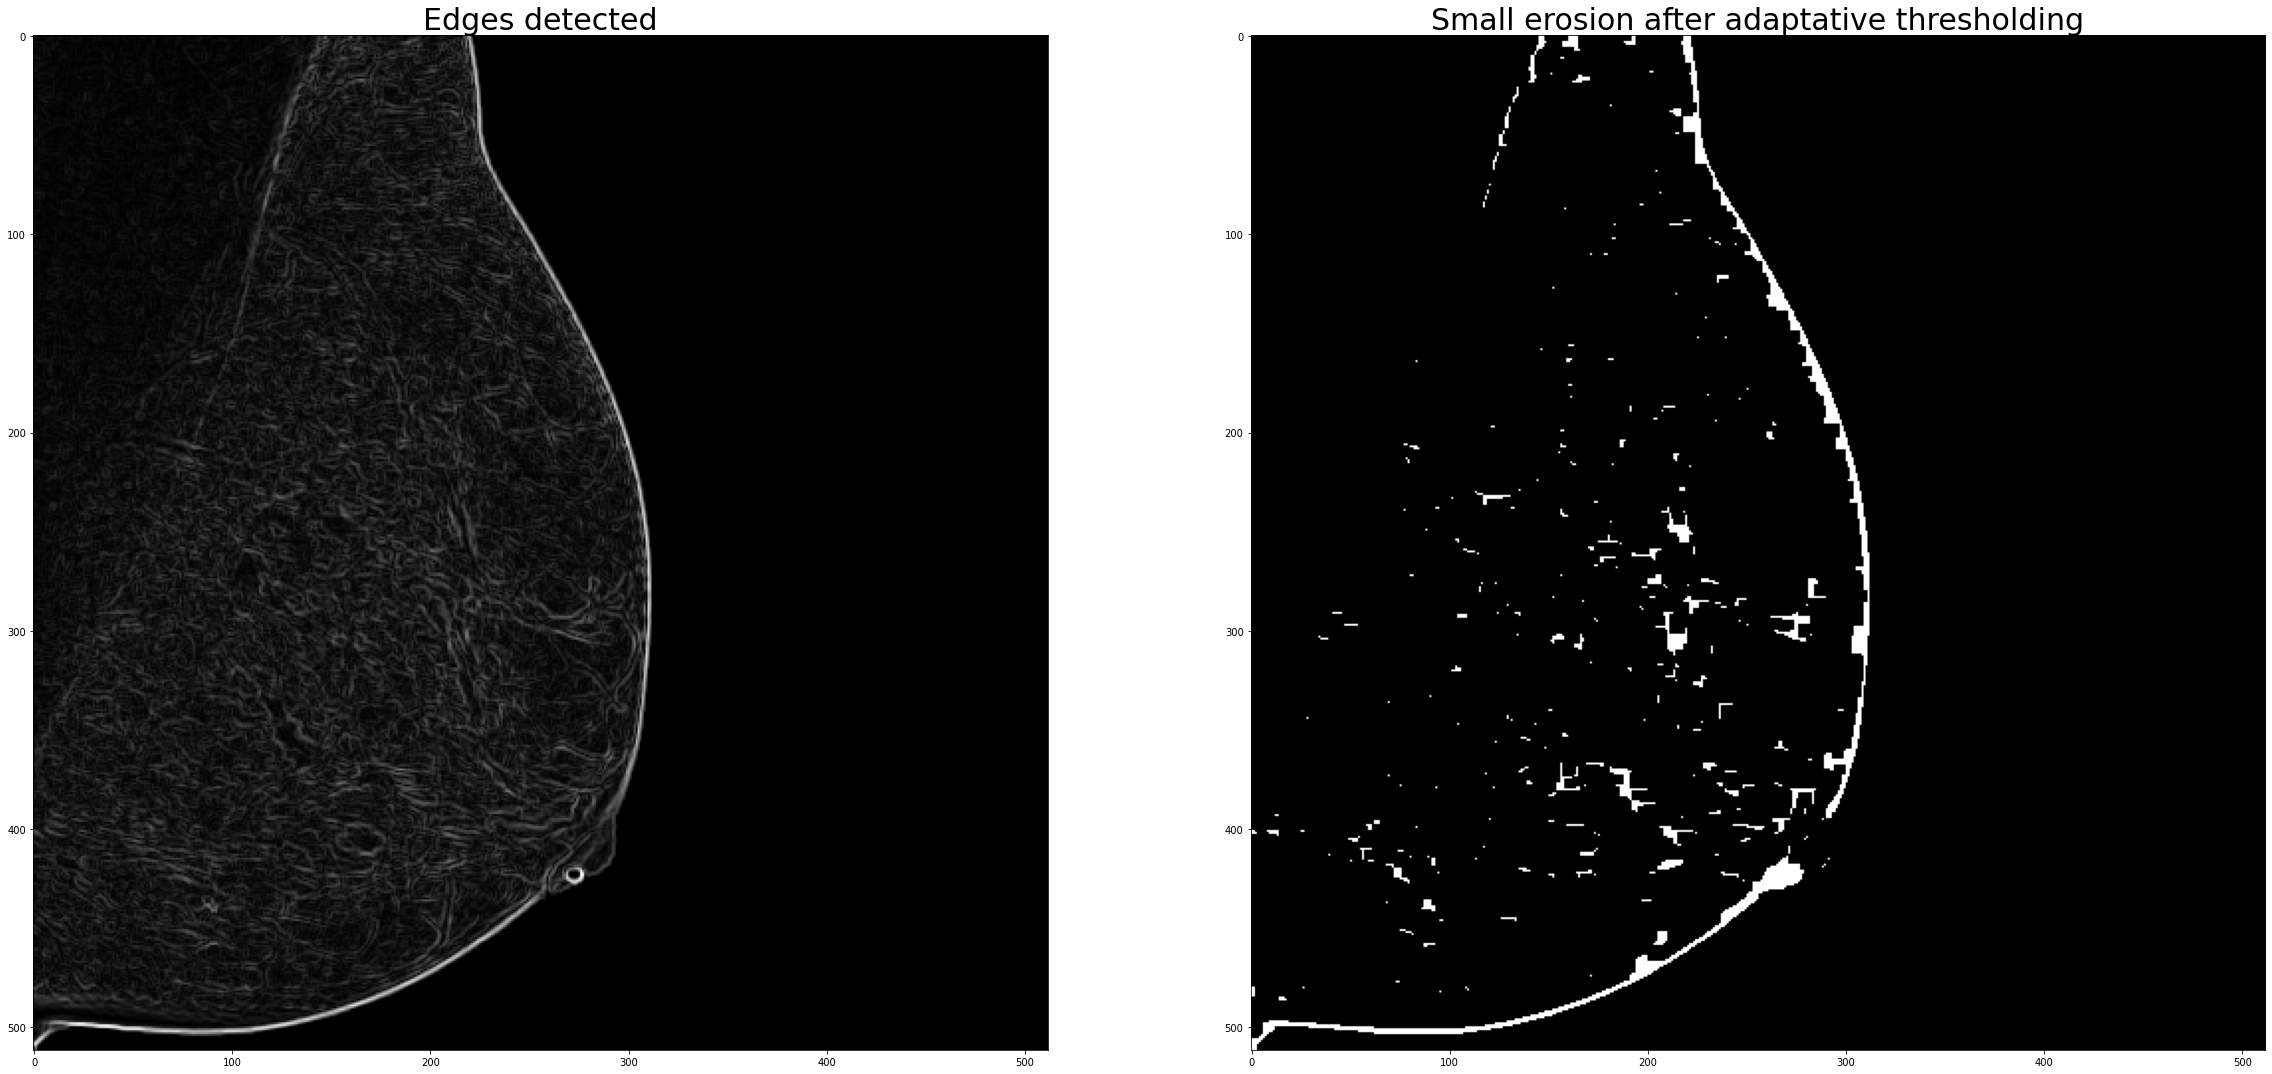

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

ax1.imshow(edges, cmap="gray")
ax1.set_title("Edges detected", fontsize=30)

ax2.imshow(Pipeline.remove_useless_edges(edges), cmap="gray")
ax2.set_title("Small erosion after adaptative thresholding", fontsize=30)

plt.show()

In [26]:
# Apply the erosion operation to the image
edges = Pipeline.remove_useless_edges(edges)
hull = Pipeline.get_convex_hull(edges)
pectoral_muscle_highlight = Pipeline.draw_convex_hull(hull,image)

Text(0.5, 1.0, 'Identification of ROI without pectoral muscle')

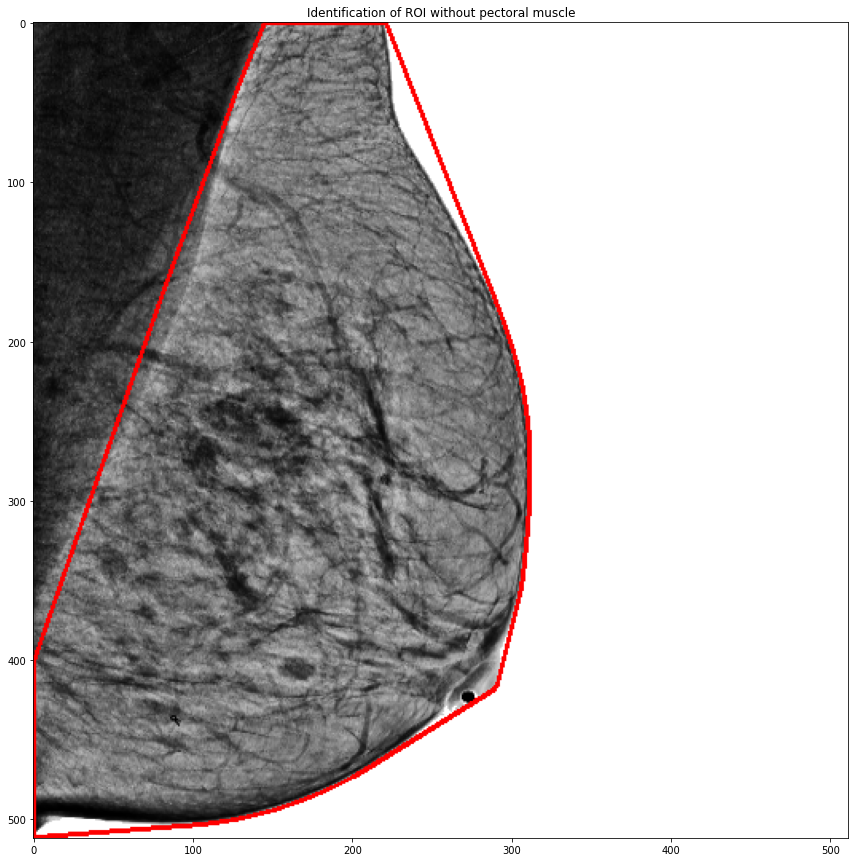

In [27]:
plt.imshow(pectoral_muscle_highlight, cmap="gray")
plt.title("Identification of ROI without pectoral muscle")

# Pipeline Test

In [28]:
Pipeline = PreProcessingPipeline(
    remove_annotation=True,
    denoising=True,
    gamma_correction=True,
    inverted_image=True,
    clahe_tileGridSize=(10, 10),
    clahe_clipLimit=1.0,
)
image = cv2.imread(examples_list_path[2])  # 10
image_pre_processed = Pipeline.pre_process(image)

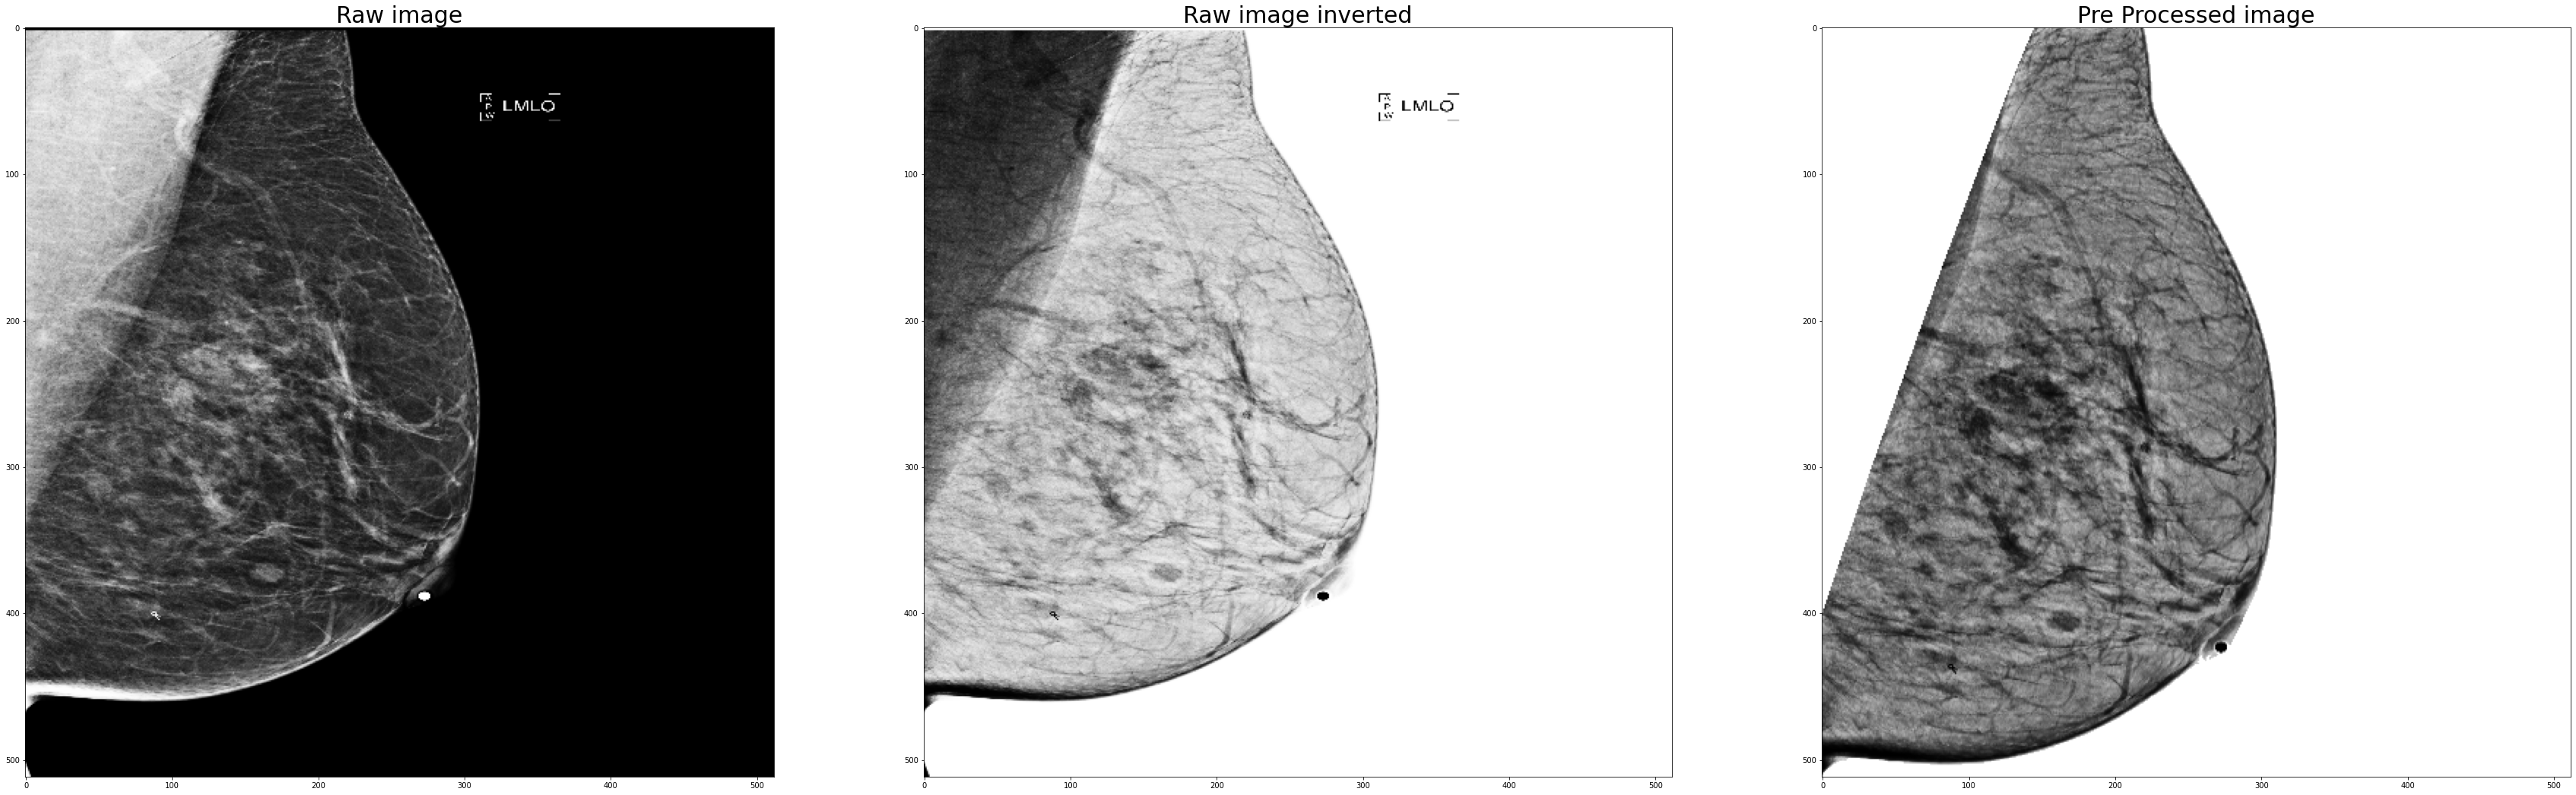

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 20))

ax1.imshow(image, cmap="gray")
ax1.set_title("Raw image", fontsize=30)

ax2.imshow(Pipeline.invert_image(image), cmap="gray")
ax2.set_title("Raw image inverted", fontsize=30)

ax3.imshow(image_pre_processed, cmap="gray")
ax3.set_title("Pre Processed image", fontsize=30)

plt.show()